<a href="https://colab.research.google.com/github/saayanbiswas/Autonomous-Car/blob/main/Behavioral_Cloning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [31]:
!unzip '/content/drive/MyDrive/CAR TRAINING DATA/DATA3.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_12_201.jpg  
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_12_303.jpg  
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_12_406.jpg  
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_12_506.jpg  
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_12_610.jpg  
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_12_712.jpg  
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_12_816.jpg  
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_12_920.jpg  
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_13_021.jpg  
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_13_124.jpg  
  inflating: /content/car training data3/IMG/right_2021_12_07_13_12_13_225.jpg  
  inflating: /content/car training data3/IMG/right_2021_12

In [32]:
datadir='/content/car training data3/'

In [33]:
!pip3 install imgaug

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

In [35]:
columns=['center', 'left','right', 'steering', 'throttle','reverse', 'speed']
data=pd.read_csv(os.path.join (datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


center  ...     speed
0  D:\Personal files\COLLEGE\AI PROJECT\car training data3\IMG\center_2021_12_07_13_08_14_864.jpg  ...  0.000082
1  D:\Personal files\COLLEGE\AI PROJECT\car training data3\IMG\center_2021_12_07_13_08_14_962.jpg  ...  0.000082
2  D:\Personal files\COLLEGE\AI PROJECT\car training data3\IMG\center_2021_12_07_13_08_15_063.jpg  ...  0.000082
3  D:\Personal files\COLLEGE\AI PROJECT\car training data3\IMG\center_2021_12_07_13_08_15_164.jpg  ...  0.000082
4  D:\Personal files\COLLEGE\AI PROJECT\car training data3\IMG\center_2021_12_07_13_08_15_268.jpg  ...  0.000083

[5 rows x 7 columns]

In [36]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()


center  ...     speed
0  center_2021_12_07_13_08_14_864.jpg  ...  0.000082
1  center_2021_12_07_13_08_14_962.jpg  ...  0.000082
2  center_2021_12_07_13_08_15_063.jpg  ...  0.000082
3  center_2021_12_07_13_08_15_164.jpg  ...  0.000082
4  center_2021_12_07_13_08_15_268.jpg  ...  0.000083

[5 rows x 7 columns]

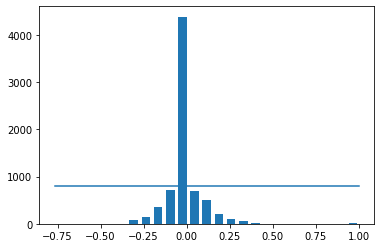

In [37]:
num_bins = 25
samples_per_bin=800
hist,bins=np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:])*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

total_data: 7308
removed: 3587
remaining: 3721


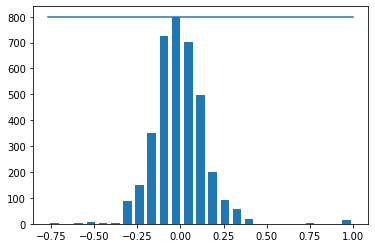

In [38]:
print('total_data:', len(data))
remove_list= []
for j in range(num_bins):
  list_= []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_= list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist,_ =np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [39]:
def load_img_steering(datadir, df):
  image_path= []
  steering= []
  for i in range(len(data)):
    indexed_data= data.iloc[i]
    center, left, right= indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings  = load_img_steering(datadir + '/IMG', data)

 

In [40]:
X_train, X_valid, y_train, y_valid= train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples:{}\nValid Samples:{}'.format(len(X_train), len(X_valid)))

Training Samples:2976
Valid Samples:745


Text(0.5, 1.0, 'Validation set')

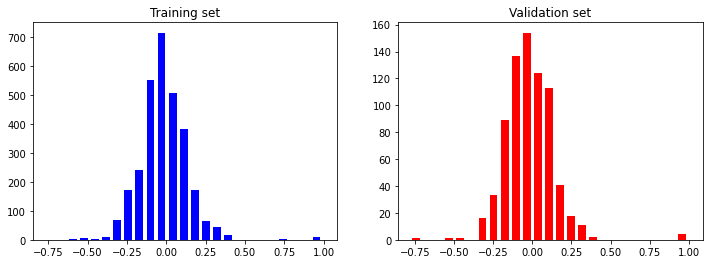

In [41]:
fig, axes= plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red' )
axes[1].set_title('Validation set')

In [42]:
def zoom(image):
  zoom= iaa.Affine(scale=(1, 1.3))
  zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed image')

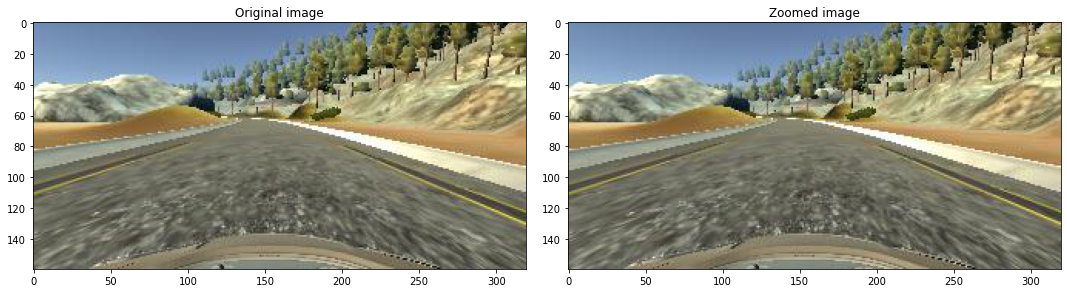

In [43]:
image= image_paths[random.randint(0,800)]
original_image= mpimg.imread(image)
zoomed_image= zoom(original_image)

fig, axs=plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed image')

In [44]:
def pan(image):
  pan=iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image=pan.augment_image(image)
  return(image)

Text(0.5, 1.0, 'Panned image')

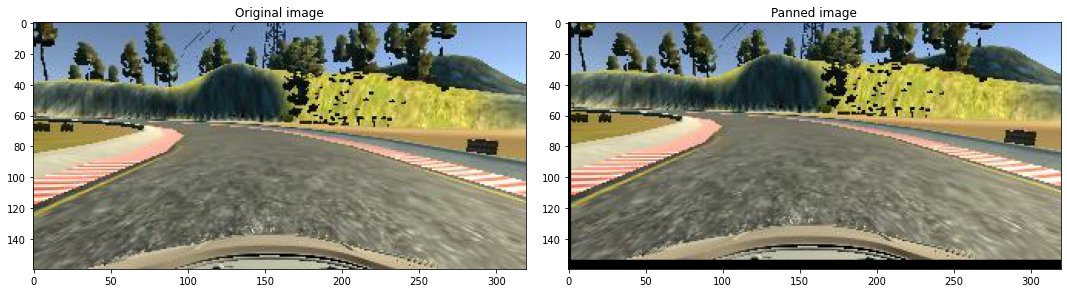

In [45]:
image= image_paths[random.randint(0,1000)]
original_image= mpimg.imread(image)
panned_image= pan(original_image)

fig, axs=plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

In [46]:
def img_random_brightness(image):
  brightness=iaa.Multiply((0.2, 1.2))
  image=brightness.augment_image(image)
  return(image)

Text(0.5, 1.0, 'random brightness image')

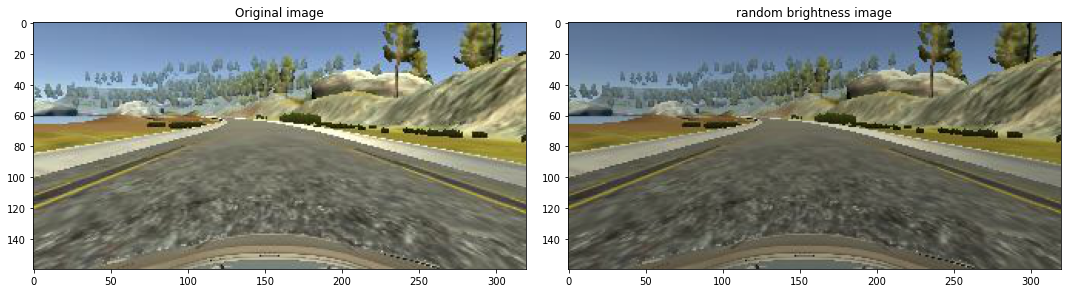

In [47]:
image= image_paths[random.randint(0,1000)]
original_image= mpimg.imread(image)
brightnessAltered_image= img_random_brightness(original_image)

fig, axs=plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(brightnessAltered_image)
axs[1].set_title('random brightness image')

In [48]:
def img_random_flip(image, steering_angle):
  image= cv2.flip(image, 1)
  steering_angle= -1*steering_angle
  return(image, steering_angle)

Text(0.5, 1.0, 'Random Flip image Steering angle:0.19632049999999998')

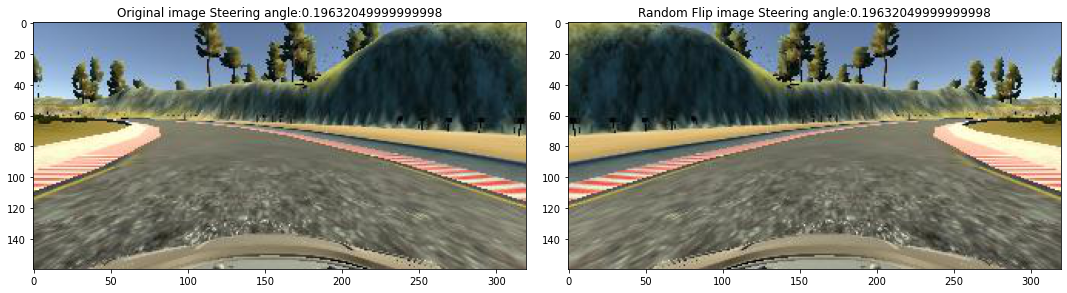

In [49]:
random_index=random.randint(0,1000)
image= image_paths[random_index]
original_image= mpimg.imread(image)
steering_angle=steerings[random_index]

randomflip_image, steering_angle= img_random_flip(original_image, steering_angle)

fig, axs=plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image'+' Steering angle:'+str(steering_angle))
axs[1].imshow(randomflip_image)
axs[1].set_title('Random Flip image'+' Steering angle:'+str(steering_angle))

In [50]:
def random_augment(image, steering_angle):
  image=mpimg.imread(image)
  #50% of images will be augmented
  if(np.random.rand() < 0.5):
    image= pan(image)
  if(np.random.rand() < 0.5):
    image= zoom(image)
  if(np.random.rand() < 0.5):
    image= img_random_brightness(image)
  if(np.random.rand() < 0.5):
    image,steering_angle= img_random_flip(image,steering_angle)

  return(image, steering_angle)  

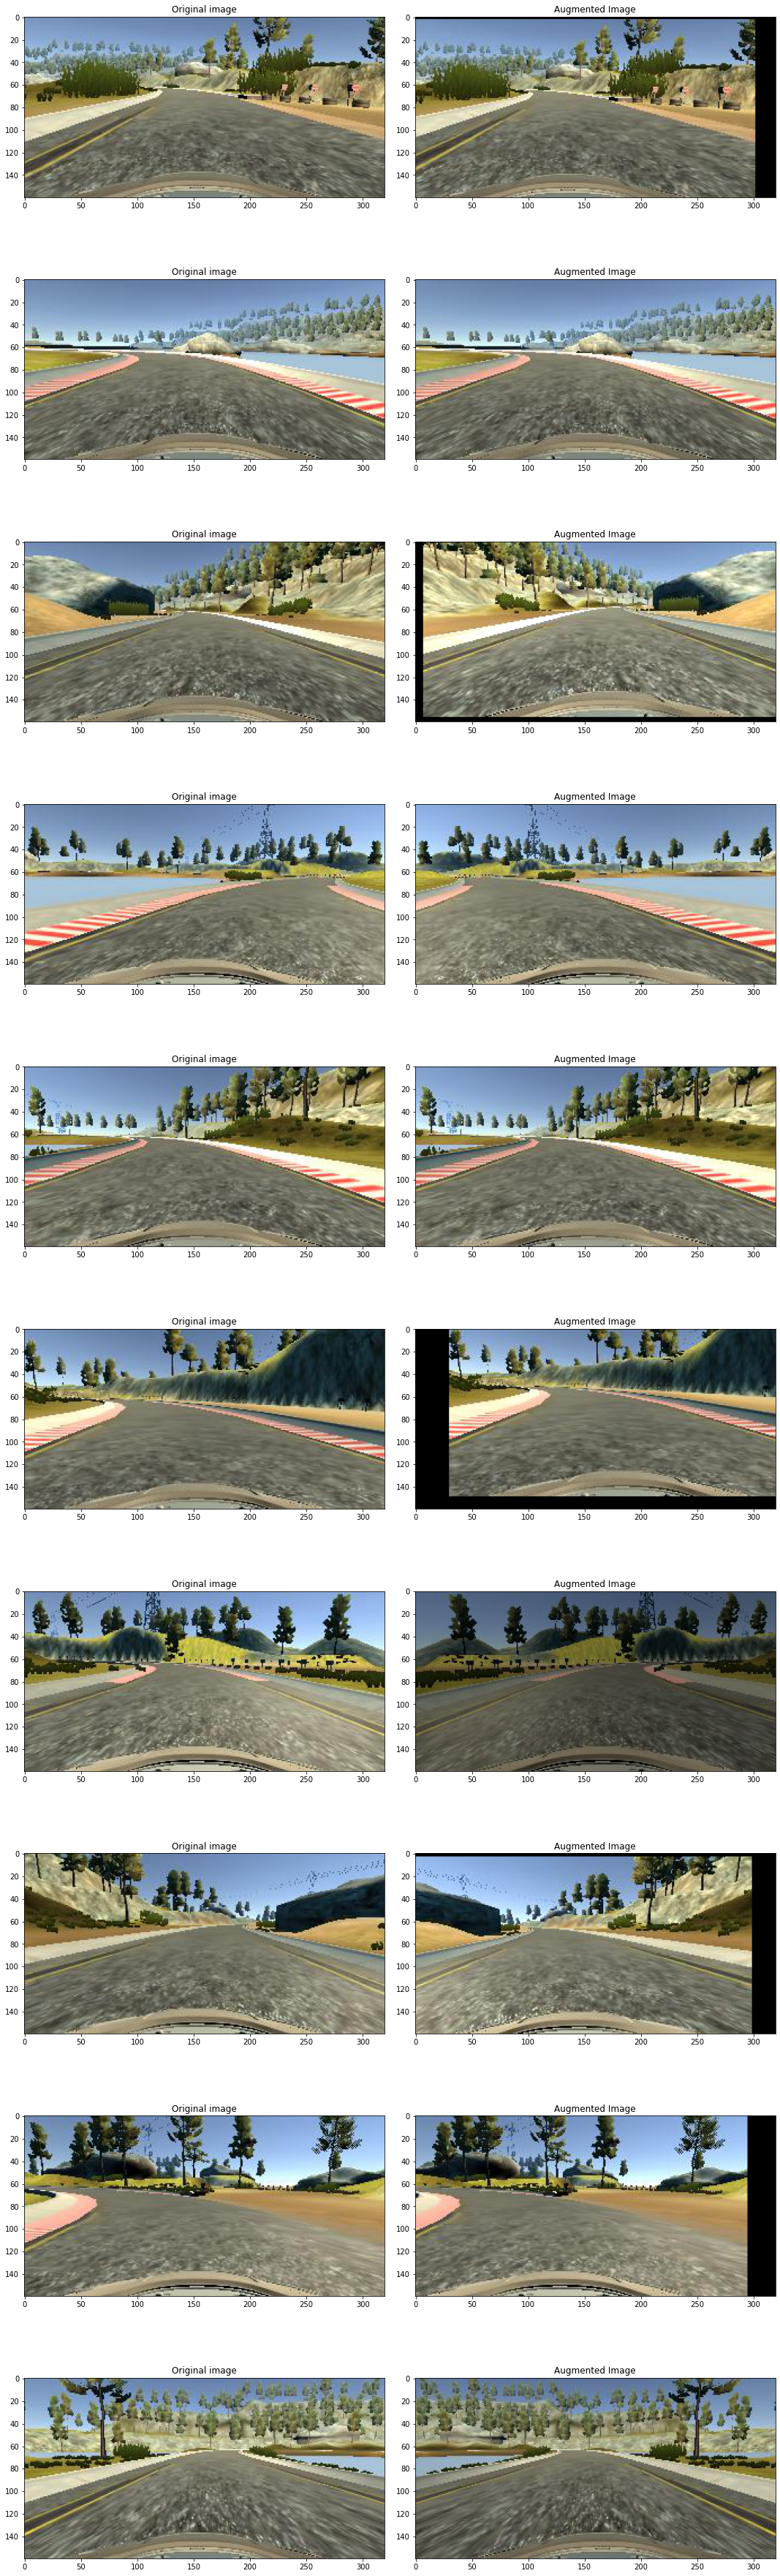

In [51]:
ncol=2
nrow=10
fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()
for i in range(10):
  randnum= random.randint(0, len(image_paths)-1)
  random_image= image_paths[randnum]
  random_steering=  steerings[randnum]

  original_image= mpimg.imread(random_image)
  augmented_image, steering= random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [52]:
def img_preprocess(img):
  #img= mpimg.imread(img) #to change 
  img= img[60:135, :, :]
  img= cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img, (3,3), 0)
  img=cv2.resize(img, (200,66))
  img=img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

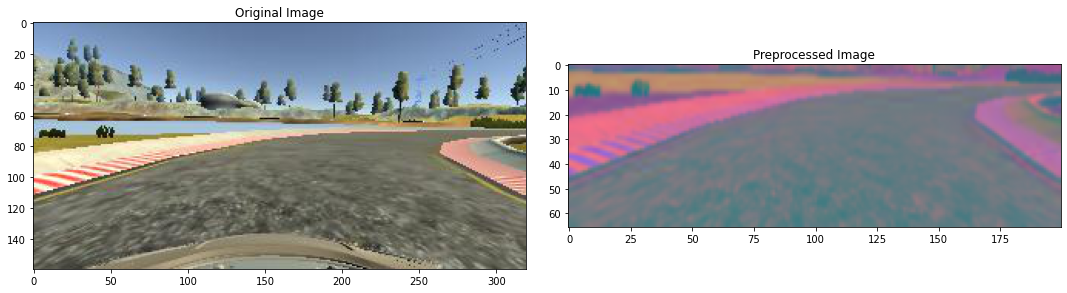

In [53]:
image = image_paths[150]
original_image= mpimg.imread(image)
preprocessed_image= img_preprocess(original_image)

fig, axs =plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [54]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img=[]
    batch_steering=[]
    

    for i in range(batch_size):
      random_index= random.randint(0, len(image_paths)-1)
      
      if(istraining):
        image = image_paths[random_index]
        image = mpimg.imread(image)
        #im, steering=random_augment(image, steering_ang[random_index])
        im, steering=random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im= mpimg.imread(image_paths[random_index])
        steering= steering_ang[random_index]
      
      im=img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))




Text(0.5, 1.0, 'Validation image')

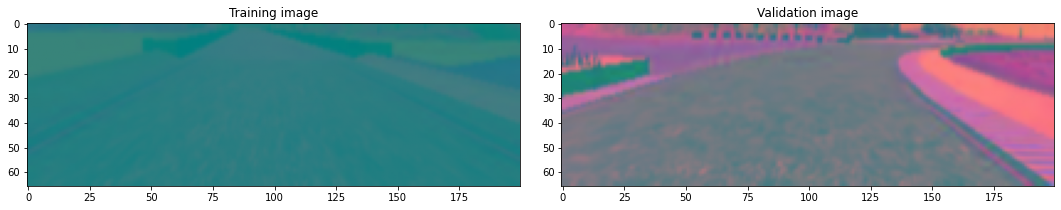

In [55]:
X_train_gen, y_train_gen= next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen= next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs=plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training image')
axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation image')

Text(0.5, 1.0, 'Preprocessed Image')

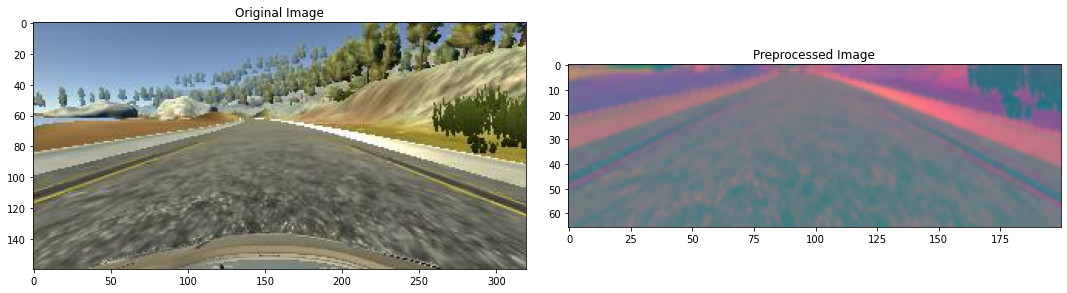

In [56]:
image = X_train[150]
original_image=mpimg.imread(image)
preprocessed_image= img_preprocess(original_image)

fig, axs =plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [60]:
def nvidia_model():
  model=Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
 #model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer= Adam(lr=0.0001)
  model.compile(loss='mse', optimizer=optimizer)
  return model


In [61]:
model= nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 100)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [62]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
300/300 [==============================] - 251s 836ms/step - loss: 0.0206 - val_loss: 0.0153
Epoch 2/10
300/300 [==============================] - 252s 843ms/step - loss: 0.0158 - val_loss: 0.0132
Epoch 3/10
300/300 [==============================] - 252s 844ms/step - loss: 0.0142 - val_loss: 0.0118
Epoch 4/10
300/300 [==============================] - 254s 848ms/step - loss: 0.0140 - val_loss: 0.0119
Epoch 5/10
300/300 [==============================] - 253s 848ms/step - loss: 0.0124 - val_loss: 0.0114
Epoch 6/10
300/300 [==============================] - 253s 848ms/step - loss: 0.0113 - val_loss: 0.0102
Epoch 7/10
300/300 [==============================] - 255s 853ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 8/10
300/300 [==============================] - 254s 849ms/step - loss: 0.0104 - val_loss: 0.0094
Epoch 9/10
300/300 [==============================] - 254s 849ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 10/10
300/300 [==============================] - 249s 834m

Text(0.5, 0, 'Epoch')

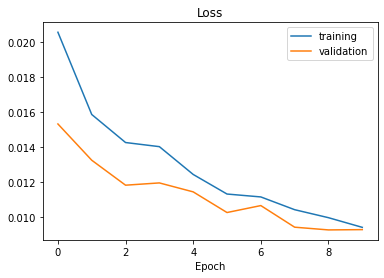

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [64]:
model.save('model.h5')

In [65]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>